In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from collections import defaultdict
from matplotlib.lines import Line2D
from matplotlib import font_manager as fm

df1 = pd.read_csv('tr_basic_cardl_20210101_20230630.csv') #롯데카드
df2 = pd.read_csv('tr_basic_cardh_20190101_20230630.csv') #하나카드
df3 = pd.read_csv('LIST_BT.csv') #종목코드

lottecard = df1[df1['mandata_brand_name'].isin(['MEGASTUDYEDU CO LTD_ALL', 'DIGITAL DAESUNG CO LTD_ALL'])]
hanacard = df2[df2['mandata_brand_name'].isin(['MEGASTUDYEDU CO LTD_ALL', 'DIGITAL DAESUNG CO LTD_ALL'])]
card_data = pd.merge(lottecard, hanacard, on=['transaction_date', 'mandata_brand_name'], how='outer')
card_data.to_csv('card_data_(mega,daesung).csv', index=False)

In [2]:
data = pd.read_csv('card_data_(mega,daesung).csv', parse_dates=['transaction_date'])
data['mon'] = data['transaction_date'].dt.month
data['year'] = data['transaction_date'].dt.year
monthly_data = data.groupby(['mandata_brand_name', 'year', 'mon']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
yearly_data = data.groupby(['mandata_brand_name', 'year']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
monthly_data['sales_all_month'] = monthly_data['sales_l'] + monthly_data['sales_h']
# monthly_data['sales_all_month'] = monthly_data['sales_h']
yearly_data['sales_all_year'] = yearly_data['sales_l'] + yearly_data['sales_h']
# yearly_data['sales_all_year'] = yearly_data['sales_h']
monthly_data = pd.merge(monthly_data, yearly_data[['mandata_brand_name', 'year', 'sales_all_year']], on=['mandata_brand_name', 'year'], how='left', suffixes=('', '_right'))

monthly_data.to_csv('sales_data_(mega,daesung).csv', index=False)

In [23]:
close_data1 = pd.read_csv('m_close.csv', parse_dates=['transaction_date'])
close_data2 = pd.read_csv('d_close.csv', parse_dates=['transaction_date'])
close_prices = pd.merge(close_data1, close_data2[['transaction_date', 'Close']], on='transaction_date', how='left', suffixes=('_company1', '_company2'))
close_prices.to_csv('stock_data_(mega,daesung).csv', index=False)

In [101]:
close_prices=pd.read_csv('stock_data_(mega,daesung).csv', parse_dates=['transaction_date'])
close_prices

,transaction_date,Close_company1,Close_company2
0,2020-01-31,11450,7570
1,2020-02-03,11150,7520
2,2020-02-04,11200,7600
3,2020-02-05,11200,7590
4,2020-02-06,11150,7680
...,...,...,...
862,2023-07-25,10090,5960
863,2023-07-26,9930,5880
864,2023-07-27,10300,5910
865,2023-07-28,10250,5810


In [25]:
df = pd.read_csv('sales_data_(mega,daesung).csv')

#연매출비교
dfsaleyear = df.groupby(['year', 'mandata_brand_name'])['sales_all_year'].first().reset_index()
total_sales_by_year = dfsaleyear.groupby('year')['sales_all_year'].transform('sum')
dfsaleyear['yearly_ratio'] = dfsaleyear['sales_all_year'] / total_sales_by_year
yearly_ratio = dfsaleyear.copy()
yearly_ratio['year'] +=1

#월매출비교
dfsalemon = df.groupby(['year', 'mon', 'mandata_brand_name'])['sales_all_month'].sum().reset_index()
total_sales_by_mon_year = dfsalemon.groupby(['mon', 'year'])['sales_all_month'].sum()
dfsalemon['monthly_ratio'] = dfsalemon.apply(lambda row: row['sales_all_month'] / total_sales_by_mon_year.loc[(row['mon'], row['year'])], axis=1)
monthly_ratio = dfsalemon.copy()

In [26]:
def my_strategy(row):
    year = row['year']
    mon = row['mon']
    name = row['mandata_brand_name']
    
    # 연도와 월, 그리고 기업에 해당하는 연도별 비율을 가져옵니다.
    yearly_ratio_value = yearly_ratio[(yearly_ratio['year'] == year) & (yearly_ratio['mandata_brand_name'] == name)]['yearly_ratio'].values
    # 연도와 월, 그리고 기업에 해당하는 월별 비율을 가져옵니다.
    monthly_ratio_value = monthly_ratio[(monthly_ratio['year'] == year) & (monthly_ratio['mon'] == mon) & (monthly_ratio['mandata_brand_name'] == name)]['monthly_ratio'].values
    
    # 연도별 비율과 월별 비율이 모두 존재하는지 확인
    if yearly_ratio_value.size > 0 and monthly_ratio_value.size > 0:
        # 월별 비율이 연도별 비율보다 높으면 매수
        if monthly_ratio_value[0] > yearly_ratio_value[0]:
            return 'buy'
        # 월별 비율이 연도별 비율보다 낮으면 매도
        elif monthly_ratio_value[0] < yearly_ratio_value[0]:
            return 'sell'
        # 비율이 같으면 보유
        else:
            return 'hold'
    else:
        # 데이터가 없는 경우
        return 'no data'

# apply 메서드를 사용하여 새로운 열을 생성합니다.
monthly_ratio['active'] = monthly_ratio.apply(my_strategy, axis=1)
monthly_ratio

monthly_ratio = monthly_ratio[monthly_ratio['active'] != 'no data']
sell_previous = monthly_ratio[monthly_ratio['active'] == 'buy']
sell_current = monthly_ratio[monthly_ratio['active'] == 'sell']
merged = sell_current.merge(sell_previous, how='outer', indicator=True)
changed_rows = merged[merged['_merge'] == 'right_only']
result = changed_rows.drop(columns=['_merge'])

def find_changed_rows(result, mandata_brand_name):
    changed_rows = result[result[mandata_brand_name] != result[mandata_brand_name].shift()]
    
    return changed_rows

changed_name_rows = find_changed_rows(result, 'mandata_brand_name')

In [113]:
changed_name_rows = changed_name_rows.copy()  # 데이터프레임의 복사본 생성
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['year'].astype(str) + '-' + changed_name_rows['mon'].astype(str))
changed_name_rows['date'] = changed_name_rows['date'] + pd.offsets.BMonthEnd()
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['date'])
changed_name_rows
#바꿀 부분
changed_name_rows.at[50, 'date'] = '2020-09-29'
changed_name_rows.at[66, 'date'] = '2022-01-28'
changed_name_rows

,year,mon,mandata_brand_name,sales_all_month,monthly_ratio,active,date
42,2020,1,DIGITAL DAESUNG CO LTD_ALL,7.653743e+08,0.225657,buy,2020-01-31
44,2020,3,MEGASTUDYEDU CO LTD_ALL,2.174432e+09,0.844700,buy,2020-03-31
49,2020,8,DIGITAL DAESUNG CO LTD_ALL,4.851676e+08,0.189146,buy,2020-08-31
50,2020,9,MEGASTUDYEDU CO LTD_ALL,1.953416e+09,0.864410,buy,2020-09-29
52,2020,11,DIGITAL DAESUNG CO LTD_ALL,5.809086e+08,0.181674,buy,2020-11-30
55,2021,2,MEGASTUDYEDU CO LTD_ALL,8.614261e+09,0.877120,buy,2021-02-26
66,2022,1,DIGITAL DAESUNG CO LTD_ALL,2.540841e+09,0.148527,buy,2022-01-28
67,2022,2,MEGASTUDYEDU CO LTD_ALL,9.270260e+09,0.871200,buy,2022-02-28
78,2023,1,DIGITAL DAESUNG CO LTD_ALL,2.345212e+09,0.121024,buy,2023-01-31
79,2023,2,MEGASTUDYEDU CO LTD_ALL,1.132871e+10,0.889544,buy,2023-02-28


In [89]:
buy_dates = []
sell_dates = []

# 마지막 매도일 설정
last_sell_date = '2023-07-31'

# 'date' 열을 날짜 형식으로 변환
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['date'])

for i in range(len(changed_name_rows)):  # 모든 행에 대해서
    buy_date = changed_name_rows.iloc[i]['date']
    buy_dates.append(buy_date)  # 매수 날짜를 buy_dates 리스트에 추가

    if i < len(changed_name_rows) - 1:  # 마지막 행을 제외한 나머지 행에 대해서
        sell_date = changed_name_rows.iloc[i + 1]['date']
        sell_dates.append(sell_date)  # 매도 날짜를 sell_dates 리스트에 추가

# 마지막 행에 해당하는 매도 날짜를 sell_dates 리스트에 추가
sell_dates.append(last_sell_date)

In [93]:
buy_dates

[Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-08-31 00:00:00'),
 Timestamp('2020-09-29 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2021-02-26 00:00:00'),
 Timestamp('2022-01-28 00:00:00'),
 Timestamp('2022-02-28 00:00:00'),
 Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-04-28 00:00:00')]

In [94]:
sell_dates

[Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-08-31 00:00:00'),
 Timestamp('2020-09-29 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2021-02-26 00:00:00'),
 Timestamp('2022-01-28 00:00:00'),
 Timestamp('2022-02-28 00:00:00'),
 Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 '2023-07-31']

In [104]:
buy_dates = []
sell_dates = []

# 마지막 매도일 설정
last_sell_date = '2023-07-31'

# 'date' 열을 날짜 형식으로 변환
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['date'])

for i in range(len(changed_name_rows)):  # 모든 행에 대해서
    buy_date = changed_name_rows.iloc[i]['date']
    buy_dates.append(buy_date)  # 매수 날짜를 buy_dates 리스트에 추가

    if i < len(changed_name_rows) - 1:  # 마지막 행을 제외한 나머지 행에 대해서
        sell_date = changed_name_rows.iloc[i + 1]['date']
        sell_dates.append(sell_date)  # 매도 날짜를 sell_dates 리스트에 추가

# 마지막 행에 해당하는 매도 날짜를 sell_dates 리스트에 추가
sell_dates.append(last_sell_date)


def calculate_long_profit(buy_price, sell_price):
    return (sell_price - buy_price) / buy_price * 100

def combine_profits(profit_company1, profit_company2, is_long_position):
    if is_long_position:
        return - profit_company1 + profit_company2
    else:
        return - profit_company2 + profit_company1

# 누적 수익률을 계산하는 함수 정의
def calculate_cumulative_profits(buy_dates, sell_dates, close_prices):
    cumulative_profits = []
    is_long_position = True
    previous_profit = 0  # 이전 누적 수익률

    for i in range(len(buy_dates)):
        buy_date = buy_dates[i]
        sell_date = sell_dates[i]

        buy_price_company1 = close_prices[close_prices['transaction_date'] == buy_date]['Close_company1'].values
        sell_price_company1 = close_prices[close_prices['transaction_date'] == sell_date]['Close_company1'].values
        buy_price_company2 = close_prices[close_prices['transaction_date'] == buy_date]['Close_company2'].values
        sell_price_company2 = close_prices[close_prices['transaction_date'] == sell_date]['Close_company2'].values

        buy_price_company1 = buy_price_company1[0]
        sell_price_company1 = sell_price_company1[0]
        buy_price_company2 = buy_price_company2[0]
        sell_price_company2 = sell_price_company2[0]

        profit_company1 = calculate_long_profit(buy_price_company1, sell_price_company1)
        profit_company2 = calculate_long_profit(buy_price_company2, sell_price_company2)
        combined_profit = combine_profits(profit_company1, profit_company2, is_long_position)

        # 현재 누적 수익률 계산
        current_profit = previous_profit + combined_profit
        cumulative_profits.append(current_profit)

        # 현재 누적 수익률을 이전 누적 수익률로 업데이트
        previous_profit = current_profit

        # 롱 포지션과 숏 포지션을 번갈아가며 거래
        is_long_position = not is_long_position

    return cumulative_profits

# 누적 수익률 계산
cumulative_profits = calculate_cumulative_profits(buy_dates, sell_dates, close_prices)

# 구간별 수익률 출력
for i, profit in enumerate(cumulative_profits):
    print(f"구간 {i+1} 누적 수익률: {profit:.2f}%")

구간 1 누적 수익률: 1.04%
구간 2 누적 수익률: 14.32%
구간 3 누적 수익률: 18.23%
구간 4 누적 수익률: -2.01%
구간 5 누적 수익률: -8.06%
구간 6 누적 수익률: -16.43%
구간 7 누적 수익률: -20.01%
구간 8 누적 수익률: -10.24%
구간 9 누적 수익률: -13.69%
구간 10 누적 수익률: -4.91%
구간 11 누적 수익률: -6.47%
구간 12 누적 수익률: -12.23%


In [108]:
saved_data = []
price_data_list = []

for i, (buy_date, sell_date) in enumerate(zip(buy_dates, sell_dates), start=1):
    price_data = close_prices[(close_prices['transaction_date'] >= buy_date) & (close_prices['transaction_date'] <= sell_date)].copy()
    
    first_price_company1 = price_data['Close_company1'].iloc[0]
    first_price_company2 = price_data['Close_company2'].iloc[0]
    
    price_data['return_company1'] = (price_data['Close_company1'] - first_price_company1) / first_price_company1
    price_data['return_company2'] = (price_data['Close_company2'] - first_price_company2) / first_price_company2
    
    if i % 2 == 0:  # 짝수 구간
        if len(saved_data) > 0:
            price_data['return_diff'] = price_data['return_company1'] - price_data['return_company2'] + saved_data[-1]
            saved_data.append(price_data['return_diff'].iloc[-1])
        else:
            price_data['return_diff'] = price_data['return_company1'] - price_data['return_company2']
            saved_data.append(price_data['return_diff'].iloc[-1])
    else:  # 홀수 구간
        if len(saved_data) > 0:
            price_data['return_diff'] = price_data['return_company2'] - price_data['return_company1'] + saved_data[-1]
            saved_data.append(price_data['return_diff'].iloc[-1])
        else:
            price_data['return_diff'] = price_data['return_company2'] - price_data['return_company1']
            saved_data.append(price_data['return_diff'].iloc[-1])
    

    price_data_list.append(price_data)
    print(f"구간 {i} 가격 데이터:")
    print(price_data)

    file_name = f"price_data_{i}.csv"
    price_data.to_csv(file_name, index=False)
    print(f"{file_name} 파일이 저장되었습니다.")

saved_data

구간 1 가격 데이터:
   transaction_date  Close_company1  Close_company2  return_company1  \
0        2020-01-31           11450            7570         0.000000   
1        2020-02-03           11150            7520        -0.026201   
2        2020-02-04           11200            7600        -0.021834   
3        2020-02-05           11200            7590        -0.021834   
4        2020-02-06           11150            7680        -0.026201   
5        2020-02-07           11400            7680        -0.004367   
6        2020-02-10           11350            7610        -0.008734   
7        2020-02-11           11400            7610        -0.004367   
8        2020-02-12           11450            7580         0.000000   
9        2020-02-13           11400            7500        -0.004367   
10       2020-02-14           11000            7550        -0.039301   
11       2020-02-17           11100            7470        -0.030568   
12       2020-02-18           10950            7470

[0.010383437263848914,
 0.14320198669170747,
 0.1822507977054747,
 -0.020107692860563048,
 -0.0806059487666991,
 -0.16433859059167985,
 -0.2001323432660487,
 -0.10238566231755174,
 -0.13685393775829183,
 -0.04912521901284114,
 -0.06472415127844007,
 -0.12229158384587263]

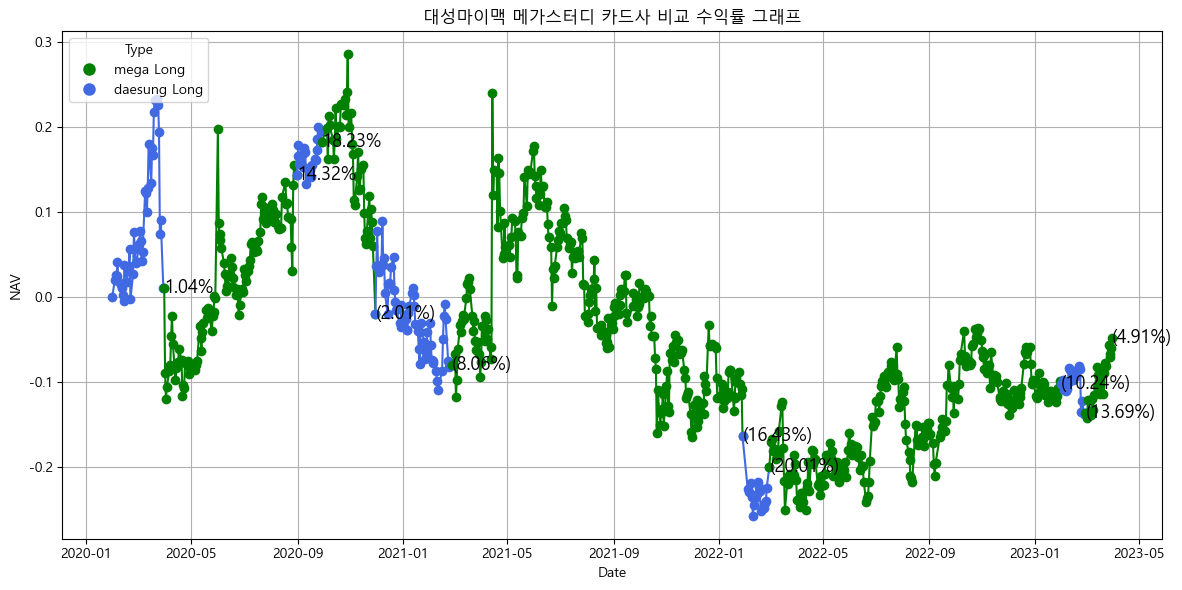

In [112]:
last_date = None
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False) 
colors = {'mega Long': 'green', 'daesung Long': 'royalblue'}  # 각 타입에 대한 색상 지정

plt.figure(figsize=(12, 6))
for i in range(1, 11):
    file_name = f"price_data_{i}.csv"
    df = pd.read_csv(file_name, parse_dates=['transaction_date'])
    df['type'] = 'daesung Long' if i % 2 == 1 else 'mega Long'  # 홀수는 현대 롱, 짝수는 신세계 롱
    df = df.sort_values(by='transaction_date')

    plt.plot(df['transaction_date'], df['return_diff'], color=colors[df['type'].iloc[0]], marker='o')
    last_value = df['return_diff'].iloc[-1]
    last_date = df['transaction_date'].iloc[-1]
    abs_last_value = abs(last_value)

    if last_value < 0:
        label_text = f"({abs_last_value * 100:.2f}%)"
    else:
        label_text = f"{abs_last_value * 100:.2f}%"

    plt.text(last_date, last_value, label_text, fontsize=13, ha='left', va='center')

    custom_legend = [
        Line2D([0], [0], color='green', marker='o', markersize=8, lw=0, label='mega Long'),
        Line2D([0], [0], color='royalblue', marker='o', markersize=8, lw=0, label='daesung Long')
    ]

plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('대성마이맥 메가스터디 카드사 비교 수익률 그래프')
plt.grid(True)
plt.tight_layout()
plt.legend(handles=custom_legend, title='Type', loc='upper left')  # 마지막 범주 설정 추가
plt.show()
